In [ ]:
# ..... get bulk and single-cell coexp cons scores across species for CHD genes ..... #

In [2]:
library(ggplot2)
library(ggridges)
library(dplyr)
library(stringr)
library(UpSetR)

# enrichment for this list
source('~/septation/gene_set_enrichment.R')
ginfo = read.delim('/data/CoCoCoNet/geneInfo/human_info.csv', sep = ',')

In [34]:
# get bulk coexp cons scores 
spe = c('human', 'chimp', 'rhesusm', 'crabm', 'mouse', 'rat', 'rabbit', 'boar', 'cow', 'dog', 'horse', 'goat',
         'sheep', 'chicken', 'zebrafish', 'atlanticsalmon', 'rainbowtrout',
         'fruitfly', 'roundworm', 'bee', 'bombyx', 'yeast', 'arabidopsis', 'maize', 'tomato')

bulkspec = read.delim('~/Primate_MTG/bulk_coexp_spec_cross_species_25.csv', sep = ',')
colids = grep(paste(spe[c(1:15)], collapse = '|'), colnames(bulkspec))
bulkspec$animal_avg = rowMeans(bulkspec[,colids], na.rm = T)

dim(bulkspec)
bulkspec[1,]

[1] 14131   302

gene human_chimp human_rhesusm human_crabm human_mouse human_rat human_rabbit
1 A1BG 0.9171331   0.6754909     0.519668    0.3459922   0.432844  0.5321471   
  human_boar human_cow human_dog ⋯ bombyx_arabidopsis bombyx_maize
1 0.8450163  0.1639923 0.9315495 ⋯ NA                 NA          
  bombyx_tomato yeast_arabidopsis yeast_maize yeast_tomato arabidopsis_maize
1 NA            NA                NA          NA           NA               
  arabidopsis_tomato maize_tomato animal_avg
1 NA                 NA           0.813818

In [49]:
# add LOF scores
gnomad = read.delim('~/Primate_MTG/gnomad.v2.1.1.lof_metrics.by_gene.txt', sep = '\t')
gnomad[1:2,]

gene  transcript      obs_mis exp_mis oe_mis  mu_mis     possible_mis
1 MED13 ENST00000397786 871     1117.8  0.77921 5.5598e-05 14195       
2 NIPBL ENST00000282516 846     1441.5  0.58688 7.3808e-05 18540       
  obs_mis_pphen exp_mis_pphen oe_mis_pphen ⋯ gene_type      gene_length
1 314           529.75        0.59273      ⋯ protein_coding 122678     
2 158           543.10        0.29092      ⋯ protein_coding 189655     
  exac_pLI exac_obs_lof exac_exp_lof exac_oe_lof brain_expression chromosome
1 1        0             64.393      0.0000000   NA               17        
2 1        1            110.570      0.0090443   NA               5         
  start_position end_position
1 60019966       60142643    
2 36876861       37066515

In [35]:
# CHD list
jin = read.delim('Jin_curated_CHD_genes.csv', sep = ',')
dim(jin)
jin[1,]

[1] 253   9

Gene  Gene.Set       Inheritance HHE.Rank pLI.Score
1 ABCC9 Human CHD Gene Monoallelic 90.3     0        
  X..of.Observed.Damaging.RGs.in.Cases observed.Cardiac.Phenotype observed.EM
1 0                                                                          
  observed.NDD
1

In [36]:
# single cell pseudobulk coexp cons
cons = read.delim('pseudobulk_scores.csv', sep = ',')
cons$CHD = 'none'
cons$CHD[cons$gene %in% jin$Gene] = 'CHD'
cons[1:2,]

gene   score     CHD 
1 SPRY2  0.8087578 none
2 PCDH20 0.8008320 none

In [37]:
# build DEGs from Supp tabes - CM2, CF3, CF4, EC2, EC3, EC4
temp1 = read.delim('DEG_CM.csv', sep = ',')
temp1 <- temp1[temp1$cluster %in% c('CM2'),]

temp2 = read.delim('DEG_CF.csv', sep = ',')
temp2 <- temp2[temp2$cluster %in% c('CF3', 'CF4'),]

temp3 = read.delim('DEG_EC.csv', sep = ',')
temp3 <- temp3[temp3$cluster %in% c('EC2', 'EC3', 'EC4'),]
colnames(temp3)[2] = 'avg_log2FC'

df1 = rbind(temp1, temp2, temp3)
df1[1:3,]

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene         
244 0     2.507633   1.000 0.965 0         CM2     ANKRD1       
245 0     2.077671   0.768 0.328 0         CM2     NPPB         
246 0     1.573570   0.757 0.281 0         CM2     RP11-309L24.2

In [52]:
# construct df with bulk and single-cell scores, and other params
newdf = data.frame(Gene = bulkspec$gene, singlecell_score = NA, bulk_score = bulkspec$animal_avg, 
                   CHD_gene = 0, CHD = 0, pLI = 0)
newdf$singlecell_score = cons$score[match(newdf$Gene, cons$gene)]

newdf$CHD_gene[which(newdf$Gene %in% jin$Gene)] = 1  # is it a known CHD gene?
newdf$CHD[which(newdf$Gene %in% df1$gene)] = 1  # is it a DEG associated with CHD cluster?

pli_score = gnomad$exac_pLI[match(newdf$Gene, gnomad$gene)]
newdf$pLI[!is.na(pli_score) & pli_score>0.9] = 1  # intolerant to LoF
newdf[1:3,]

Gene  singlecell_score bulk_score CHD_gene CHD pLI
1 A1BG         NA        0.8138180  0        0   0  
2 A1CF  0.7998821        0.9341217  0        0   0  
3 A2ML1 0.7683261        0.7901946  0        0   0

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1265 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1265 rows containing missing values (`geom_point()`).”


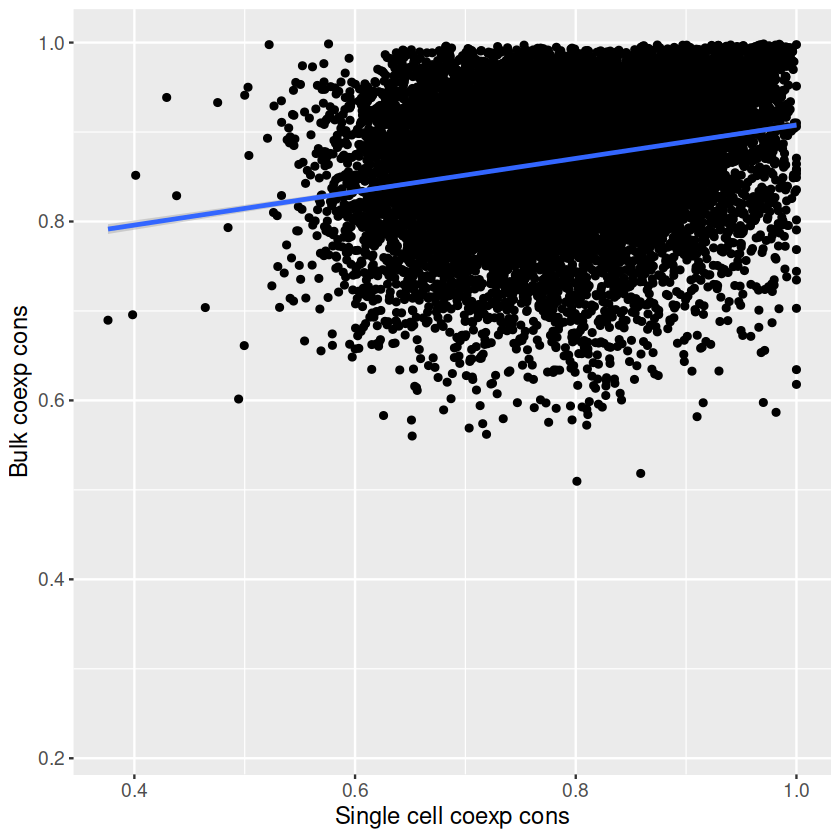

In [39]:
# png('aa-sc-pli-coexpcons.png', width = 8, height = 8, res = 300, units = 'in')
ggplot(newdf, aes(x = singlecell_score, y = bulk_score)) + geom_point() + geom_smooth(method = 'lm') + 
theme(text = element_text(size=14)) + #facet_wrap(~cluster) + 
xlab('Single cell coexp cons') + ylab('Bulk coexp cons')
# dev.off()

In [59]:
# compare with control vs disease coexp cons
des = read.delim('DEG_shared.txt', sep = '\t')
des[1,]

Intersect                          nGenes
1 DCM HCM HLHS_DN-HLHS HLHS_fail TOF 34    
  Gene_symbol                                                                                                                                                                                                               
1 BTG2 RTN4 FOSL2 ZNF189 HEPH AASS PM20D2 FRMD5 TIPARP C14orf132 MID1 ECE1 SOCS2 CEBPD PSMD8 C5orf46 YBX3 ADAMTS9-AS2 WNT9A NEURL1B FKBP5 TLE4 IRS2 PROS1 CEBPB KRBA1 TMTC1 LEPREL1 SCGB3A2 MAFF SLC7A8 PITPNB LPHN3 GADD45B

In [60]:
# df/matrix for upset plot for each category
allgenes = c()
conds = c('DCM', 'HCM', 'HLHS_DN-HLHS', 'HLHS_fail', 'TOF')
upset_mat = matrix(0, nrow = sum(des[,2]), ncol = length(conds))
colnames(upset_mat) = conds
ctr = 0

for(ii in 1:dim(des)[1]){
    dlist = unlist(str_split(des[ii,1], ' '))
    glist = unlist(str_split(des[ii,3], ' '))
    allgenes = c(allgenes, glist)
    
    for(jj in 1:length(glist)){
        ctr = ctr + 1
        upset_mat[ctr, match(dlist, conds)] = 1
    }
}
upset_mat2 = upset_mat
upset_mat2[upset_mat2>0] = 1                                   
upset_df = data.frame(allgenes, upset_mat2)
upset_df[1:3,]

allgenes DCM HCM HLHS_DN.HLHS HLHS_fail TOF
1 BTG2     1   1   1            1         1  
2 RTN4     1   1   1            1         1  
3 FOSL2    1   1   1            1         1

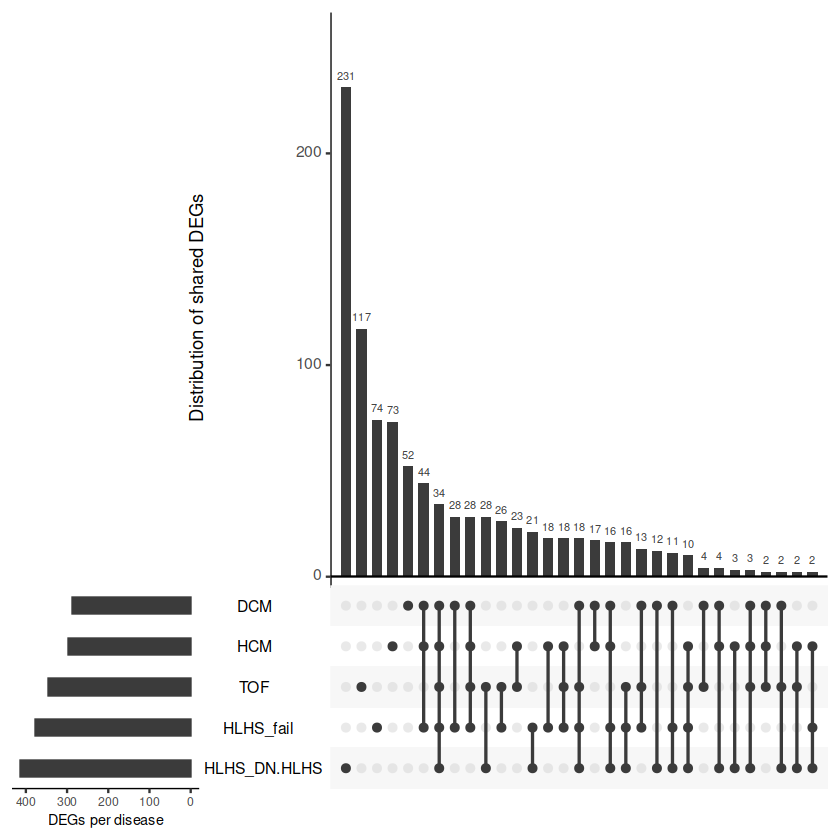

In [61]:
# png('AAAA-spe-div-upset.png', width = 5, height = 5, res = 300, units = 'in')
# pdf('AAAA-spe5-crossspe-cls-upset.pdf', width = 8, height = 8)
upset(upset_df, order.by = 'freq',  
      mainbar.y.label = "Distribution of shared DEGs",
      sets.x.label = "DEGs per disease", keep.order = TRUE, text.scale = c(1.3, 1.3, 1, 1, 1.3, 1))
# dev.off()

In [62]:
# add DEG shared from Supp Tabe to our list of disease genes
newdf$CHD[newdf$Gene %in% allgenes] = 1
sum(newdf$CHD)

[1] 1786

In [70]:
# get potential gene set
temp = newdf[!is.na(newdf$singlecell_score),]
dim(temp)
temp2 = temp[temp$CHD_gene==0 & temp$singlecell_score>0.95,]
temp2 <- temp2[!is.na(temp2$bulk_score),]

# re-order with disease DEG and high cons in our data
temp2 <- temp2[with(temp2, order(-CHD, -pLI, -singlecell_score)), ]
dim(temp2)
sum(temp2$CHD)
sum(temp2$pLI)
temp2[1:2,]

[1] 12917     6

[1] 640   6

[1] 108

[1] 157

Gene    singlecell_score bulk_score CHD_gene CHD pLI
8639 PITPNC1 0.9957024        0.8256721  0        1   1  
3414 EEF1A1  0.9904411        0.9614385  0        1   1

In [73]:
# save
write.table(temp2, file = '20240213_candidate_CHD_genes.csv', sep = ',', row.names = F, 
            col.names = T, quote = F)

In [66]:
# GSE for gene sets
divgenes = unique(temp2$Gene[temp2$pLI==1])
divgenes2 = ginfo$NetworkIDs[match(divgenes, ginfo$GeneSymbol)]
divgenes2 = divgenes2[!is.na(divgenes2)]
gse = gene_set_enrichment(divgenes2, 'human')
head(gse)

GO_term   
GO:0019080 GO:0019080
GO:0019083 GO:0019083
GO:0072599 GO:0072599
GO:0006614 GO:0006614
GO:0006413 GO:0006413
GO:0070972 GO:0070972
           description                                                   
GO:0019080 viral gene expression                                         
GO:0019083 viral transcription                                           
GO:0072599 establishment of protein localization to endoplasmic reticulum
GO:0006614 SRP-dependent cotranslational protein targeting to membrane   
GO:0006413 translational initiation                                      
GO:0070972 protein localization to endoplasmic reticulum                 
           N_sample N_univ pvals        adj_pvals    sig 
GO:0019080 23       149    5.158969e-25 3.716695e-21 TRUE
GO:0019083 22       131    8.268509e-25 3.716695e-21 TRUE
GO:0072599 22       140    3.853414e-24 1.024240e-20 TRUE
GO:0006614 21       121    4.874606e-24 1.024240e-20 TRUE
GO:0006413 23       166    6.835864e-24 1.024240e-20 TRUE
GO:0070972 23       166    6.835864e-24 1.024240e-20 TRUE

In [74]:
temp3 = temp2[temp2$CHD==1 & temp2$bulk_score>0.9,]
temp3$Gene
temp3 <- temp3[with(temp3, order(-pLI, -bulk_score)), ]
head(temp3)

[1] "EEF1A1"   "MAP4"     "GNAQ"     "KANK2"    "COL4A5"   "PABPC1"  
 [7] "PTPRB"    "TNS1"     "LAMC1"    "SHROOM4"  "ACTC1"    "HSP90AB1"
[13] "DLC1"     "PTPRD"    "SLMAP"    "MAP1B"    "MMP16"    "FLT1"    
[19] "TENM3"    "EEF2"     "COL4A1"   "MSN"      "DLL4"     "TNFRSF1A"
[25] "ACTN2"    "CRIM1"    "FOXP1"    "GLI2"     "SLIT2"    "ZMIZ1"   
[31] "CACNA2D1" "TGFB2"    "TCF7L2"   "CD58"     "COL24A1"  "EXOC4"   
[37] "UBC"      "AHNAK"    "XIRP2"    "PTMA"     "RPL31"    "FKBP1A"  
[43] "TNFRSF1B" "SPC25"    "JPH2"     "COL4A2"   "KREMEN1"  "FRAS1"   
[49] "HMCN2"    "TIE1"     "CASP8"    "TTN"      "DIAPH1"   "SELE"    
[55] "NDUFB4"   "TNNT2"    "FMNL3"    "NDUFS5"   "SKP1"     "AFAP1"   
[61] "FLI1"     "ATP6V1F"  "FGF14"    "MEF2A"    "SEC24D"   "ZCCHC24" 
[67] "KLHL6"    "PNRC1"    "ACTA1"    "SLC5A1"   "HMCN1"    "VWF"     
[73] "EIF3I"    "FBLN1"    "PRRX1"    "CSRP3"    "ARHGEF40"

Gene     singlecell_score bulk_score CHD_gene CHD pLI
12415 TNFRSF1A 0.9575444        0.9810369  0        1   1  
12460 TNS1     0.9760413        0.9768106  0        1   1  
180   ACTN2    0.9571829        0.9754844  0        1   1  
6148  LAMC1    0.9731717        0.9751755  0        1   1  
4237  FLT1     0.9650834        0.9736122  0        1   1  
2442  COL4A1   0.9637539        0.9731893  0        1   1